In [1]:
!pip install python-igraph==0.9.6
!pip install cairocffi
!pip install IPython
!wget https://raw.githubusercontent.com/Mehrdadghassabi/SDF-Implementation/master/topology_matrix.txt
!wget https://raw.githubusercontent.com/Mehrdadghassabi/SDF-Implementation/master/marking_vector.txt
!wget https://raw.githubusercontent.com/Alireza-Ghafouri/SDF-Implementation/master/actor_process_times.txt

     |████████████████████████████████| 3.2 MB 28.2 MB/s 
     |████████████████████████████████| 88 kB 8.0 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=1268414943474ff2714085464feafa20ffaf3bca3691d45f50f26d886e4db1fb
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi
--2022-05-07 07:14:07--  https://raw.githubusercontent.com/Mehrdadghassabi/SDF-Implementation/master/topology_matrix.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526 [text/plain]
Saving to: ‘topology_matrix.txt’

topology_matrix.txt 100%[===================>]     526  --.-KB/s    in 0s      

2022-05-07 07:14:07 (23.0 MB/s) - ‘topology_matrix.txt’ saved

In [2]:
from igraph import *
import igraph as ig

In [3]:
def read_file():
    file = open("topology_matrix.txt", "rt")
    matrix = [[int(num) for num in line.split(",")] for line in file.readlines()]
    file = open("marking_vector.txt", "rt")
    marking = [int(line) for line in file.readlines()]
    file = open("actor_process_times.txt", "rt")
    actor_process_times = [int(num) for num in file.readline().split(",")]
    return matrix, marking, actor_process_times

In [4]:
class actor:
    def __init__(self, proc_time, inp, out):
        self.proc_time = int(proc_time)
        self.busy = False
        self.input = []
        self.input = inp
        self.output = []
        self.output = out
        self.timer = 0

In [5]:
def ready_to_fire(node):
    global num_of_in_tokens
    global user_tokens
    if len(node.input) == 0:
        if num_of_in_tokens < user_tokens:
            return True
        return False
    temp = 0
    for item in node.input:
        if marking[item[0]] >= item[1]:
            temp += 1
    if temp == len(node.input):
        return True
    return False

In [6]:
def print_log(actor_token_number, status, token_time):
    if status == "activated":
        result = str(token_time) + ": actor number " + str(actor_token_number) + " " + status
        if actor_token_number == 0:
            result = str(token_time) + ": SRC " + status
        elif actor_token_number == len(actor_process_times) - 1:
            result = str(token_time) + ": SNK " + status

    elif status == "fired":
        result = str(token_time) + ": actor number " + str(actor_token_number) + " " + status
        if actor_token_number == 0:
            result = str(token_time) + ": SRC " + status
        elif actor_token_number == len(actor_process_times) - 1:
            result = str(token_time) + ": SNK " + status
    elif status == "exited":
        result = str(token_time) + ": out token " + str(actor_token_number) + " " + status + " from SNK"

        global latency
        global throughput_temp
        global throughput
        global f

        # global max_time_distance
        # global last_token_time
        # if max_time_distance < token_time - last_token_time:
        #     max_time_distance= token_time - last_token_time
        # last_token_time=token_time

        if actor_token_number == wanted_token_for_latency:
            latency = token_time - producer_node_first_activation
            throughput_temp = token_time
        elif actor_token_number == wanted_token_for_latency + 1:
            throughput = "1/" + str(token_time - throughput_temp)

    # print(result)
    # print(" ")
    f.write(result)
    f.write("\n")

In [7]:
def draw_graph():
    global actor_process_times
    global matrix

    g = Graph(directed=True)

    # add vertices
    g.add_vertices(len(actor_process_times))
    for i in range(len(g.vs)):
        g.vs[i]["id"] = i

        if i == 0:
            g.vs[i]["label"] = "SRC"
        elif i == len(actor_process_times) - 1:
            g.vs[i]["label"] = "SNK"
        else:
            # g.vs[i]["label"]= str(i)
            g.vs[i]["label"] = str(actor_process_times[i])

    # add edges
    edges = []
    weights = []
    labels = []
    for e in range(len(matrix)):
        weights.append(0)
        for v in range(len(actor_process_times)):
            if matrix[e][v] > 0:
                temp1 = matrix[e][v]
                v1 = v
            elif matrix[e][v] < 0:
                temp2 = -1 * matrix[e][v]
                v2 = v
        edges.append((v1, v2))
        labels.append(str(temp1) + "..." + str(temp2))

    g.add_edges(edges)
    g.es['weight'] = weights
    g.es['label'] = labels
    # ig.plot(g)
    ###########################
    visual_style = {}
    out_name = "graph.png"
    # Set bbox and margin
    visual_style["bbox"] = (1400, 800)
    visual_style["margin"] = 27
    # Set vertex colours
    visual_style["vertex_color"] = 'yellow'
    # Set vertex size
    visual_style["vertex_size"] = 60
    # Set vertex lable size
    visual_style["vertex_label_size"] = 22
    # Don't curve the edges
    visual_style["edge_curved"] = False
    # Set the layout
    my_layout = g.layout_lgl()
    visual_style["layout"] = my_layout
    # Plot the graph
    ig.plot(g, out_name, **visual_style)

In [8]:
time_limit = int(input("time limitation:"))
user_tokens = int(input("number of input tokens:"))
matrix, marking, actor_process_times = read_file()
f = open("System_Report.txt", 'w')
actor_list = []

f.write("--------------------------------------------\n")
f.write("         HISTORY OF EVENTS\n")
f.write("--------------------------------------------\n")

# FORMING ACTOR LISTS
for i in range(len(actor_process_times)):  # actors
    inp = []
    out = []
    for x in range(len(matrix)):  # edges
        if matrix[x][i] > 0:
            out.append([x, matrix[x][i]])
        elif matrix[x][i] < 0:
            inp.append([x, -1 * matrix[x][i]])

    actor_list.append(actor(actor_process_times[i], inp, out))

# MAIN

latency = 0
throughput_temp = 0
throughput = ""
# last_token_time=0
# max_time_distance=0
wanted_token_for_latency = 0
total_time = 0
num_of_out_tokens = 0
num_of_in_tokens = 0
num_of_initial_tokens = 0
for x in marking:
    num_of_initial_tokens += x
while total_time <= time_limit and num_of_out_tokens <= num_of_initial_tokens + user_tokens:
    for node in actor_list:
        if node.busy:
            node.timer += 1
            if node.timer == node.proc_time:
                for item in node.output:
                    marking[item[0]] += item[1]
                node.timer = 0
                node.busy = False
                print_log(actor_list.index(node), "fired", total_time)
        if ready_to_fire(node) == True and node.busy == False:

            if actor_list.index(node) == 0:
                num_of_in_tokens += 1
                if num_of_in_tokens == 1:  # Producer Node First Fire
                    producer_node_first_activation = total_time
                    producer_node_input_edges = [ind[0] for ind in node.input]
                    all_toknes = 0
                    temp_tokens = 0
                    for temp in marking:
                        all_toknes += temp
                    for i in producer_node_input_edges:
                        temp_tokens += marking[i]
                    wanted_token_for_latency = all_toknes - temp_tokens + num_of_out_tokens + 1

            print_log(actor_list.index(node), "activated", total_time)

            if actor_process_times[0] == 0 and actor_list.index(node) == 0:
                print_log(actor_list.index(node), "fired", total_time)
                for i in range(user_tokens - 1):
                    print_log(actor_list.index(node), "activated", total_time)
                    print_log(actor_list.index(node), "fired", total_time)

                for item in node.output:
                    marking[item[0]] += item[1] * user_tokens
                num_of_in_tokens += user_tokens - 1

                node.busy = False


            else:
                for item in node.input:
                    marking[item[0]] -= item[1]
                node.busy = True

            if len(node.output) == 0:
                num_of_out_tokens += 1
                print_log(num_of_out_tokens, "exited", total_time)
                node.busy = False

    total_time += 1

# nm_throughput= "1/" + str(max_time_distance)


# PRINTING RESULTS

if num_of_out_tokens == 0:
    # print("No output token!")
    f.write("No output token!\n")
# print("--------------------------------------------")
# print("         SYSTEM FUNCTION")
# print("--------------------------------------------")
f.write("--------------------------------------------\n")
f.write("         SYSTEM FUNCTION\n")
f.write("--------------------------------------------\n")
if latency == 0:
    if wanted_token_for_latency == 0:
        # print("Time limitation too law!")
        # print("The producer actor even did not fire!")
        f.write("Time limitation too law!\n")
        f.write("The producer actor even did not fire!\n")
    else:
        # print("Unable to calculate latency!")
        # print("     Not enough time limitation!")
        f.write("Unable to calculate latency!\n")
        f.write("     Not enough time limitation!\n")
    # print("Unable to calculate throughput!")
    # print("     Not enough time limitation!")
    f.write("Unable to calculate throughput!\n")
    f.write("     Not enough time limitation!\n")
else:
    # print("Latency:",latency)
    # print("Throughput:" , throughput)
    f.writelines(["Latency: ", str(latency), "\n"])
    if throughput == "":
        f.write("Unable to calculate throughput!\n")

    else:
        f.writelines(["Throughput: ", str(throughput), "\n"])

    # if max_time_distance==0:
    #     print ("the time limitation you entered was not enough to calculate the certain throughput of the system")
    # else:
    #     print("Non Memmory Throughput:" ,nm_throughput )

# print("--------------------------------------------")
# print("         FINAL SYSTEM INFO")
# print("--------------------------------------------")
# print("End system marking:")
# print(" ")
f.write("--------------------------------------------\n")
f.write("         FINAL SYSTEM INFO\n")
f.write("--------------------------------------------\n")
f.write("End system marking:\n")
f.write("\n")

edge = 1
for x in marking:
    # print(" Edge" , edge , ":" , x)
    f.writelines([" Edge", str(edge), ": ", str(x), "\n"])
    edge += 1
num_of_busy_actors = 0
for act in actor_list:
    if act.busy:
        num_of_busy_actors += 1

# print(" ")
# print("Number of tokens entered the system:" , num_of_in_tokens)
# print("Number of tokens left the system:" , num_of_out_tokens)
# print("Number of initial tokens:" , num_of_initial_tokens)
# print("Number of busy actors :", num_of_busy_actors)
# print("--------------------------------------------")
f.write("\n")
f.writelines(["Number of tokens entered the system: ", str(num_of_in_tokens), "\n"])
f.writelines(["Number of tokens left the system: ", str(num_of_out_tokens), "\n"])
f.writelines(["Number of initial tokens: ", str(num_of_initial_tokens), "\n"])
f.writelines(["Number of busy actors : ", str(num_of_busy_actors), "\n"])
# f.write("--------------------------------------------\n")

time limitation:20
number of input tokens:10


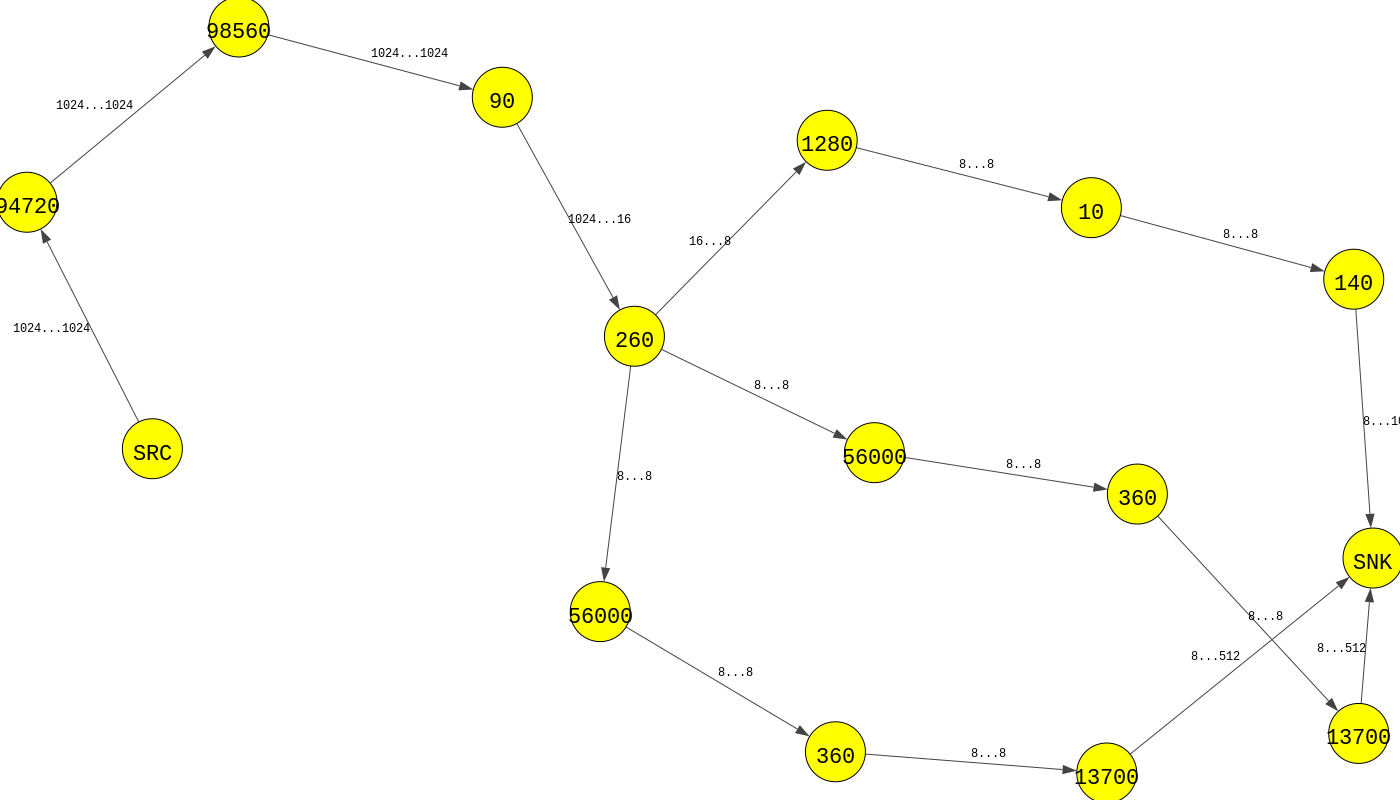

In [9]:
draw_graph()
from IPython.display import Image
Image(filename='graph.png') 